### PA 3 Sentiment Classification

*First, the basics*

In [21]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import cohen_kappa_score
from plotnine import *
import string
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score

*NLP Setups*

In [22]:
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS

In [23]:
punct = string.punctuation
print(punct)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [24]:
stopwords = list(STOP_WORDS)
print(len(stopwords))

326


In [25]:
nlp = spacy.load("en_core_web_sm")

*Functions for data cleaning*

In [26]:
def dataCleaning(sentence):
  doc = nlp(sentence)
  tokens = []
  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_tokens = []
  for token in tokens:
    if token not in punct and token not in stopwords:
      clean_tokens.append(token)
  return clean_tokens

In [27]:
dataCleaning('I am my Hero hero CAD!')

['hero', 'hero', 'cad']

### The evaluation on the constistance of the two datasets

*Crowd sourced data*

In [28]:
crowdsourcedTrain = pd.read_csv('crowdsourced_train.csv', sep='\t')
X1 = crowdsourcedTrain['text']
y1 = crowdsourcedTrain['sentiment']
crowdsourcedTrain.shape

(10676, 2)

*We need to make sure exact only three classes(neutral, positive and negative)*

In [29]:
y1[y1.str.contains('eu|al')] = 'neutral'
y1[y1.str.contains('pos|Pos')] = 'positive'
y1[y1.str.contains('gat|neg|Neda')] = 'negative'

*Gold data*

In [30]:
goldTrain = pd.read_csv('gold_train.csv', sep='\t')
goldTrain.head()
X2 = goldTrain['text']
y2 = goldTrain['sentiment']

*Compare them*

*Cohen K is 0.4462, not a good sign*

In [31]:
cohen_kappa_score(y1, y2)

0.44628451952213066

*Distribution difference*

In [32]:
y1.value_counts()

sentiment
neutral     5079
positive    3219
negative    2378
Name: count, dtype: int64

d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


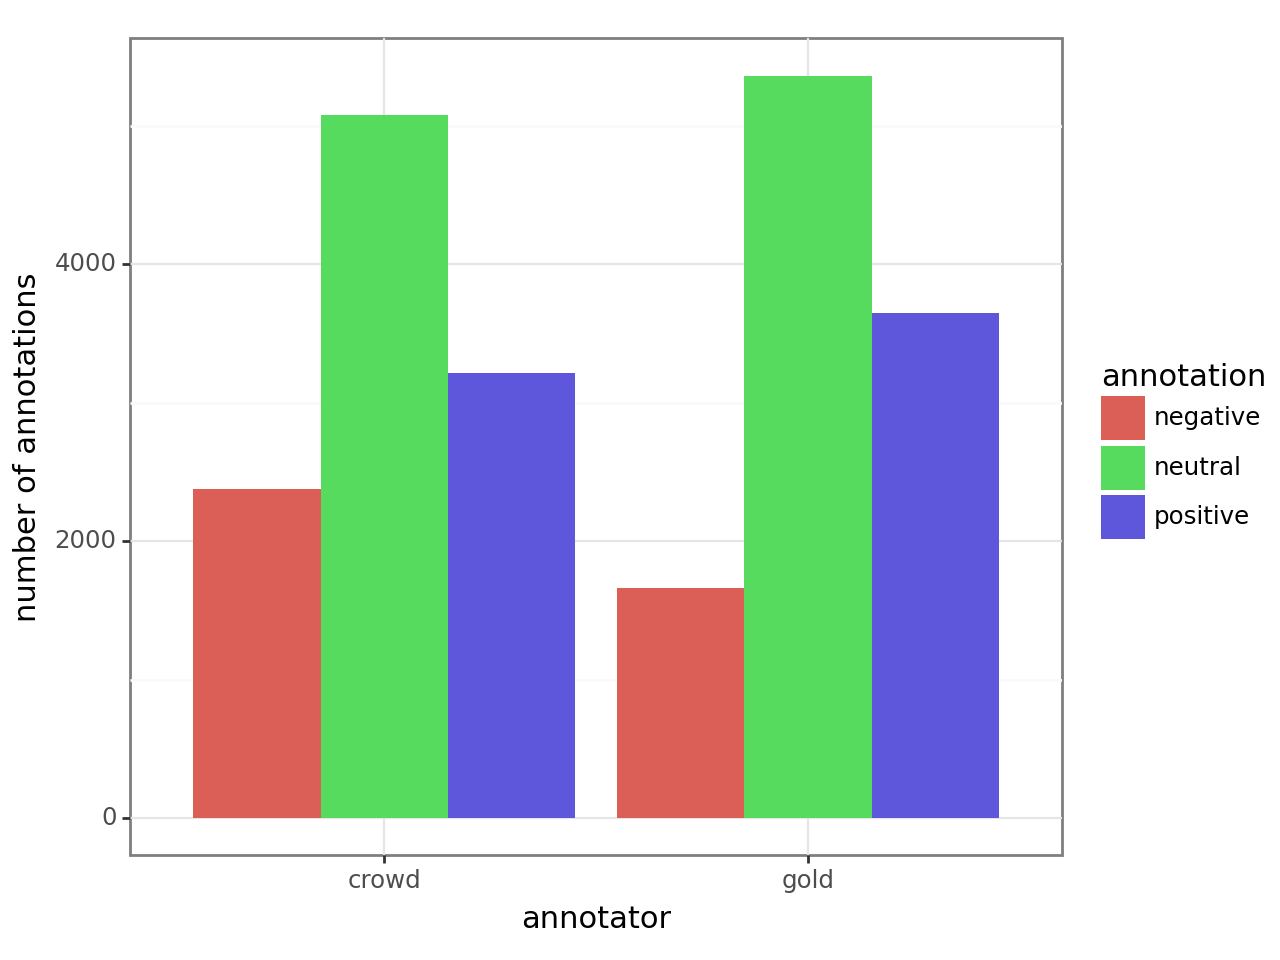

<Figure Size: (640 x 480)>

In [33]:
df_crowd = pd.DataFrame({'annotator':'crowd', 'annotation':['neutral', 'positive', 'negative'], 'times':y1.value_counts()})
df_gold = pd.DataFrame({'annotator':'gold', 'annotation':['neutral', 'positive', 'negative'], 'times':y2.value_counts()})
df_differ = pd.concat([df_crowd, df_gold])
df_differ = pd.melt(df_differ, id_vars=['annotator', 'annotation'], value_vars=['times'])
df_differ = df_differ.drop('variable', axis=1)

p1 = (ggplot(df_differ, aes(x = 'annotator', y = 'value', fill = 'annotation'))
      + geom_bar(stat = 'identity', position = 'dodge')
      + labs(y = 'number of annotations')
      # + geom_area()
      + theme_minimal()
      + theme_bw()
      )
p1

*Test data*

In [34]:
test = pd.read_csv('test.csv', sep='\t')
Xtest = test['text']
ytest = test['sentiment']
test.shape

(5524, 2)

*Split the data 
for potential use*

In [35]:
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=423)
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=423)
Xtest3, ytest3 = test['text'], test['sentiment']

### Classifier based on crowdsourced data & gold data and the prediction evaluation

*test of this cleaning function*

In [36]:
dataCleaning("The work you chose has a practical vein. But I read much more into your name. Lifeguard. Patrolling the length and the breadth of your pool. I call your name from the vestibule")

['work',
 'choose',
 'practical',
 'vein',
 'read',
 'lifeguard',
 'patrol',
 'length',
 'breadth',
 'pool',
 'vestibule']

*This is the vectorizer without cleanning function, many unrelevant words involved:*

In [37]:
CountVectorizer().fit(["The work you chose has a practical vein. But I read much more into your name. Lifeguard. Patrolling the length and the breadth of your pool. I call your name from the vestibule"]).get_feature_names_out()

array(['and', 'breadth', 'but', 'call', 'chose', 'from', 'has', 'into',
       'length', 'lifeguard', 'more', 'much', 'name', 'of', 'patrolling',
       'pool', 'practical', 'read', 'the', 'vein', 'vestibule', 'work',
       'you', 'your'], dtype=object)

*So one can guess that with this cleaning function, we can better retrieve useful informations from documents*

*Basics of 2 schemes of countvectorizer, and double check*

*The first one is based on bag-of-words scheme*

In [38]:
count = CountVectorizer()
count.fit_transform(Xtrain1)[10].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 2395, 19060, 16073,  6876,  9042,  7988, 19646,  5137, 18966,
        11033, 12608, 12234, 17381, 10362,  2063,  5421, 19175,  4708]))

*The second one is binary occurrence markers*

In [39]:
count = CountVectorizer(binary =  True)
count.fit_transform(Xtrain1)[10].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 2395, 19060, 16073,  6876,  9042,  7988, 19646,  5137, 18966,
        11033, 12608, 12234, 17381, 10362,  2063,  5421, 19175,  4708]))

*Basics for First scheme*

In [40]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", message="ConvergenceWarning:*")

*Before tunning the hyperparameter C*

In [41]:
pipeLogreg0 = Pipeline([('TfidfVectorizer', TfidfVectorizer()),
                 ('logitreg', LogisticRegression(max_iter= 500))])
print(f'The parameter C of the log reg is:{pipeLogreg0.named_steps["logitreg"].C}\n')
print(f'The cv mean accuracy based on crowd data: {np.mean(cross_val_score(pipeLogreg0, X1, y1))}')
print(f'The prediction accuracy based on crowd data: {pipeLogreg0.fit(X1, y1).score(Xtest3, ytest3)}\n')

print(f'The cv mean accuracy based on gold data: {np.mean(cross_val_score(pipeLogreg0, X2, y2))}')
print(f'The prediction accuracy based on gold data: {pipeLogreg0.fit(X2, y2).score(Xtest3, ytest3)}\n')

print(f'The number of features that we utilized: {len(pipeLogreg0.named_steps["TfidfVectorizer"].get_feature_names_out())}')
# np.sum(pipe1.named_steps['TfidfVectorizer'].get_feature_names_out() == 'We')

The parameter C of the log reg is:1.0

The cv mean accuracy based on crowd data: 0.5741853713303336
The prediction accuracy based on crowd data: 0.6241853729181752

The cv mean accuracy based on gold data: 0.6455595610872826
The prediction accuracy based on gold data: 0.7148805213613324

The number of features that we utilized: 22918


*Check for the dimensions*

In [42]:
TfidfVectorizer().fit_transform(X1, y1).shape

(10676, 22918)

*Now we try to tune the model. After tunning based on the cross validation, the performance improves alot on gold data but not on the crowd data.*

In [43]:
parameters = {'C':range(1,50,3)}
# parameters = {'C': np.logspace(-4, 4, 20)} 

pipelogreg1 = Pipeline([
  ('TfidfVectorizer', TfidfVectorizer()),
  # ('SelectKBest', SelectKBest(k = 20000)),
  # ('logitreg', LogisticRegression(C = 20, max_iter= 500)),
  ('logrg', GridSearchCV(LogisticRegression(max_iter= 500), param_grid=parameters, n_jobs= -1))
])

# print(f'The cv mean accuracy based on crowd data: {np.mean(cross_val_score(pipeLogreg0, X1, y1))}')
print(f'the prediction accuracy based on crowd data: {pipelogreg1.fit(X1, y1).score(Xtest3, ytest3)}')
print(f'the parameter C of the log reg is:{pipelogreg1.named_steps["logrg"].best_params_}')
print(f'the CV mean score of the log reg is:{pipelogreg1.named_steps["logrg"].best_score_}\n')

# print(f'The cv mean accuracy based on gold data: {np.mean(cross_val_score(pipeLogreg0, X2, y2))}')
print(f'the prediction accuracy based on gold data: {pipelogreg1.fit(X2, y2).score(Xtest3, ytest3)}')
print(f'the parameter C of the log reg is:{pipelogreg1.named_steps["logrg"].best_params_}')
print(f'the CV mean score of the log reg is:{pipelogreg1.named_steps["logrg"].best_score_}\n')

print(f'the number of features that we utilized: {len(pipelogreg1.named_steps["TfidfVectorizer"].get_feature_names_out())}')

the prediction accuracy based on crowd data: 0.6241853729181752
the parameter C of the log reg is:{'C': 1}
the CV mean score of the log reg is:0.5754033453499285

the prediction accuracy based on gold data: 0.7887400434467777
the parameter C of the log reg is:{'C': 4}
the CV mean score of the log reg is:0.6466840775728231

the number of features that we utilized: 22918


*Now we add the cleaning function (less features) and repite. Not much difference, even worse.*

In [44]:
pipeLogreg02 = Pipeline([('TfidfVectorizer', TfidfVectorizer(tokenizer = dataCleaning, token_pattern=None)),
                 ('logitreg', LogisticRegression(max_iter= 500))])

print(f'The parameter C of the log reg is:{pipeLogreg02.named_steps["logitreg"].C}\n')
print(f'The cv mean accuracy based on crowd data: {np.mean(cross_val_score(pipeLogreg02, X1, y1))}')
print(f'The prediction accuracy based on crowd data: {pipeLogreg02.fit(X1, y1).score(Xtest3, ytest3)}\n')

print(f'The cv mean accuracy based on gold data: {np.mean(cross_val_score(pipeLogreg02, X2, y2))}')
print(f'The prediction accuracy based on gold data: {pipeLogreg02.fit(X2, y2).score(Xtest3, ytest3)}\n')

print(f'The number of features that we utilized: {len(pipeLogreg02.named_steps["TfidfVectorizer"].get_feature_names_out())}')

The parameter C of the log reg is:1.0

The cv mean accuracy based on crowd data: 0.5763398065065038
The prediction accuracy based on crowd data: 0.6211078928312816

The cv mean accuracy based on gold data: 0.641437956652545
The prediction accuracy based on gold data: 0.7016654598117307

The number of features that we utilized: 21061


*Tune the hyperparameter C same way:*

In [45]:
parameters = {'C':range(1,50,3)}
# parameters = {'C': np.logspace(-4, 4, 20)} 

pipelogreg12 = Pipeline([
  ('TfidfVectorizer', TfidfVectorizer(tokenizer = dataCleaning, token_pattern=None)),
  # ('SelectKBest', SelectKBest(k = 20000)),
  # ('logitreg', LogisticRegression(C = 20, max_iter= 500)),
  ('logrg', GridSearchCV(LogisticRegression(max_iter= 500), param_grid=parameters, n_jobs= -1))
])

# print(f'The cv mean accuracy based on crowd data: {np.mean(cross_val_score(pipeLogreg0, X1, y1))}')
print(f'the prediction accuracy based on crowd data: {pipelogreg12.fit(X1, y1).score(Xtest3, ytest3)}')
print(f'the parameter C of the log reg is:{pipelogreg12.named_steps["logrg"].best_params_}')
print(f'the CV mean score of the log reg is:{pipelogreg12.named_steps["logrg"].best_score_}\n')

# print(f'The cv mean accuracy based on gold data: {np.mean(cross_val_score(pipeLogreg0, X2, y2))}')
print(f'the prediction accuracy based on gold data: {pipelogreg12.fit(X2, y2).score(Xtest3, ytest3)}')
print(f'the parameter C of the log reg is:{pipelogreg12.named_steps["logrg"].best_params_}')
print(f'the CV mean score of the log reg is:{pipelogreg12.named_steps["logrg"].best_score_}\n')

print(f'the number of features that we utilized: {len(pipelogreg12.named_steps["TfidfVectorizer"].get_feature_names_out())}')

the prediction accuracy based on crowd data: 0.6211078928312816
the parameter C of the log reg is:{'C': 1}
the CV mean score of the log reg is:0.571562727503969

the prediction accuracy based on gold data: 0.7764301230992035
the parameter C of the log reg is:{'C': 4}
the CV mean score of the log reg is:0.6420940452069572

the number of features that we utilized: 21061


*As we can see, even the cleanning function makes alot of sense but decrease the accuracy, so we won't use it.*

*The second scheme, we treat the features as binary(1 or 0, indicating of absence) not one-of-bags anymore. Considering that the data are very short text so this also make sense.*

*Before tunning the hyperparameter C*

In [46]:
binpipe0 = Pipeline([('count', CountVectorizer(binary =  True)),
                 ('logitreg', LogisticRegression(max_iter= 500))])
print(f'the parameter C of the log reg is:{binpipe0.named_steps["logitreg"].C}')
print(f'the prediction accuracy based on crowd data: {binpipe0.fit(X1, y1).score(Xtest3, ytest3)}')
print(f'the prediction accuracy based on gold data: {binpipe0.fit(X2, y2).score(Xtest3, ytest3)}')
print(f'the number of features that we utilized: {len(binpipe0.named_steps["count"].get_feature_names_out())}')

the parameter C of the log reg is:1.0
the prediction accuracy based on crowd data: 0.6167632150615496
the prediction accuracy based on gold data: 0.7958001448225923
the number of features that we utilized: 22918


*Tunning the parameter doesn't improve anything, we still get the default C, which is 1.*

In [47]:
parameters = {'C':range(1,50,3)}

binpipe1 = Pipeline([
  ('count', CountVectorizer(binary =  True)),
  # ('SelectKBest', SelectKBest(k = 20000)),
  # ('logitreg', LogisticRegression(C = 20, max_iter= 500)),
  ('logrg', GridSearchCV(LogisticRegression(max_iter= 500), param_grid=parameters, n_jobs= -1))
])

print(f'the prediction accuracy based on crowd data: {binpipe1.fit(X1, y1).score(Xtest3, ytest3)}')

print(f'the parameter C of the log reg is:{binpipe1.named_steps["logrg"].best_params_}')
print(f'the prediction accuracy based on gold data: {binpipe1.fit(X2, y2).score(Xtest3, ytest3)}')

print(f'the parameter C of the log reg is:{binpipe1.named_steps["logrg"].best_params_}')
print(f'the number of features that we utilized: {len(binpipe1.named_steps["count"].get_feature_names_out())}')
print(binpipe1.named_steps["logrg"].best_params_)
binpipe1.named_steps["logrg"].best_score_

the prediction accuracy based on crowd data: 0.6167632150615496
the parameter C of the log reg is:{'C': 1}
the prediction accuracy based on gold data: 0.7958001448225923
the parameter C of the log reg is:{'C': 1}
the number of features that we utilized: 22918
{'C': 1}


0.6376918488891228

### Confusion matrix

*We utilize the best classifier from above (logistic regressor with C = 1 for crowd data & logistic regressor with C = 4 for gold data)*

In [48]:
parameters = {'C':range(1,50,3)}
# parameters = {'C': np.logspace(-4, 4, 20)} 

pipelogreg1 = Pipeline([
  ('TfidfVectorizer', TfidfVectorizer()),
  # ('SelectKBest', SelectKBest(k = 20000)),
  # ('logitreg', LogisticRegression(C = 20, max_iter= 500)),
  ('logrg', GridSearchCV(LogisticRegression(max_iter= 500), param_grid=parameters, n_jobs= -1))
])

# print(f'The cv mean accuracy based on crowd data: {np.mean(cross_val_score(pipeLogreg0, X1, y1))}')
print(f'the prediction accuracy based on crowd data: {pipelogreg1.fit(X1, y1).score(Xtest3, ytest3)}')
print(f'the parameter C of the log reg is:{pipelogreg1.named_steps["logrg"].best_params_}')
print(f'the CV mean score of the log reg is:{pipelogreg1.named_steps["logrg"].best_score_}\n')
print(f'the top 10 features:{pipelogreg1.named_steps["logrg"].coef_}\n')


# print(f'The cv mean accuracy based on gold data: {np.mean(cross_val_score(pipeLogreg0, X2, y2))}')
print(f'the prediction accuracy based on gold data: {pipelogreg1.fit(X2, y2).score(Xtest3, ytest3)}')
print(f'the parameter C of the log reg is:{pipelogreg1.named_steps["logrg"].best_params_}')
print(f'the CV mean score of the log reg is:{pipelogreg1.named_steps["logrg"].best_score_}\n')

print(f'the number of features that we utilized: {len(pipelogreg1.named_steps["TfidfVectorizer"].get_feature_names_out())}')

the prediction accuracy based on crowd data: 0.6241853729181752
the parameter C of the log reg is:{'C': 1}
the CV mean score of the log reg is:0.5754033453499285

the prediction accuracy based on gold data: 0.7887400434467777
the parameter C of the log reg is:{'C': 4}
the CV mean score of the log reg is:0.6466840775728231

the number of features that we utilized: 22918


In [196]:
pipeCrowd = Pipeline([
  ('TfidfVectorizer', TfidfVectorizer()),
  ('logitreg', LogisticRegression(C = 1, max_iter= 500))
])

y_predict1 = pipeCrowd.fit(X1, y1).predict(Xtest)
y_predict1

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

In [197]:
pipeGold = Pipeline([
  ('TfidfVectorizer', TfidfVectorizer()),
  ('logitreg', LogisticRegression(C = 1, max_iter= 500))
])

y_predict2 = pipeCrowd.fit(X2, y2).predict(Xtest)
y_predict2

array(['neutral', 'negative', 'neutral', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [198]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [205]:
ytest.value_counts()

sentiment
neutral     2597
positive    1850
negative    1077
Name: count, dtype: int64

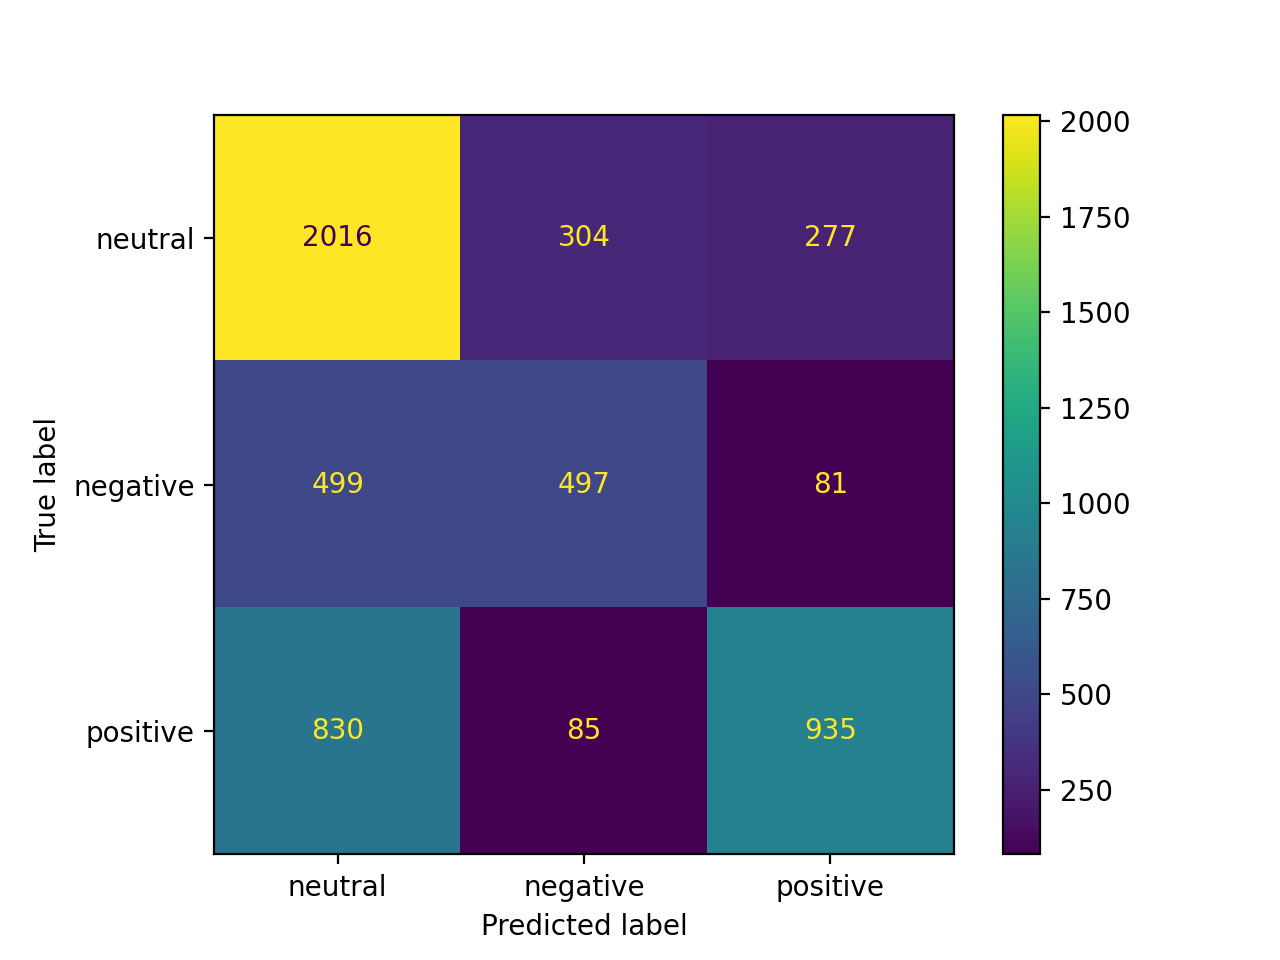

In [204]:
labels=['neutral', 'negative', 'positive']
cm = confusion_matrix(ytest, y_predict1, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

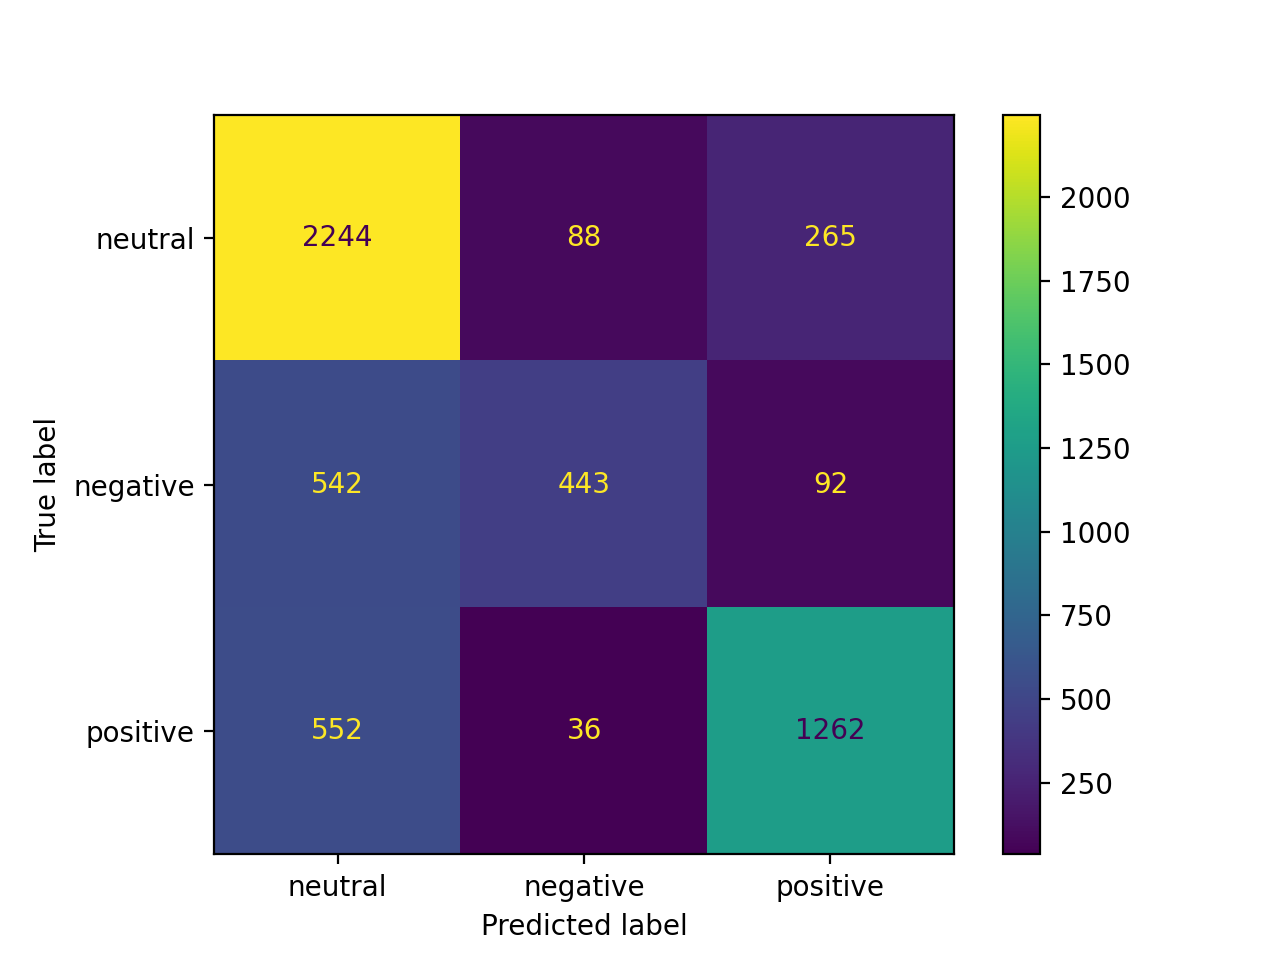

In [206]:
labels=['neutral', 'negative', 'positive']
cm = confusion_matrix(ytest, y_predict2, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

*At last we want to now the most important 10 features:*

In [59]:
pipe1 = Pipeline([
  ('TfidfVectorizer', TfidfVectorizer()),
  # ('SelectKBest', SelectKBest(k = 20000)),
  ('logitreg', LogisticRegression(C = 1, max_iter= 500)),
  # ('logrg', GridSearchCV(LogisticRegression(max_iter= 500), param_grid=parameters, n_jobs= -1))
])
pipe1.fit(X1, y1).named_steps["logitreg"].coef_[1][1]
pipe1.fit(X1, y1)
feature_names = pipe1.named_steps['TfidfVectorizer'].get_feature_names_out()
coefficients = pipe1.named_steps['logitreg'].coef_[0]
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

top_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[:10]]
print("Top 10 features with highest absolute coefficients:")
for feature, coefficient in top_features:
    print(f"{feature}: {coefficient}")

Top 10 features with highest absolute coefficients:
worst: 2.7642705986929665
sad: 2.680926466129559
muslims: 2.325795438497267
fuck: 2.288223817250294
yakub: 2.1543324209428514
hate: 2.1329775726484184
love: -1.919281114684299
shit: 1.8651733926560083
don: 1.8530770412696125
stupid: 1.7608263026778093


In [60]:
pipe2 = Pipeline([
  ('TfidfVectorizer', TfidfVectorizer()),
  # ('SelectKBest', SelectKBest(k = 20000)),
  ('logitreg', LogisticRegression(C = 4, max_iter= 500)),
  # ('logrg', GridSearchCV(LogisticRegression(max_iter= 500), param_grid=parameters, n_jobs= -1))
])
pipe2.fit(X2, y2)
feature_names = pipe2.named_steps['TfidfVectorizer'].get_feature_names_out()
coefficients = pipe2.named_steps['logitreg'].coef_[0]
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

top_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[:10]]
print("Top 10 features with highest absolute coefficients:")
for feature, coefficient in top_features:
    print(f"{feature}: {coefficient}")

Top 10 features with highest absolute coefficients:
worst: 5.521908058443699
fuck: 4.93544493861487
shit: 3.676758538016379
stupid: 3.6758643211199513
ira: 3.5817601822615583
lost: 3.5672733194084763
don: 3.5638154396560147
bitch: 3.4031904100487083
hate: 3.36545477750763
sad: 3.2454631576294504
